W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


[OK] 등록 폰트: NanumGothic @ /usr/share/fonts/truetype/nanum/NanumGothic.ttf


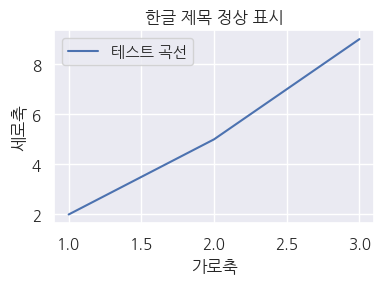

In [5]:
# ========================================================================================
# [Colab 전용] 그래프 한글 깨짐 완전 해결용 셀(현재 셀 먼저 실행)
#  - 코랩 런타임은 리눅스, 윈도우/맥 폰트 없음 → 한글 네모로 깨짐
#  - 해결: CJK 폰트 설치 → Matplotlib 캐시 초기화 → 폰트 파일을 '직접 등록' → 전역 적용
#  - 한 번만 실행하면 이후 모든 그래프(ROC/PR/혼동행렬 등) 한글로 정상 출력됨!!!
# =========================================================================================

# 1) CJK 한글 폰트 설치 (나눔/노토)
!apt-get -qq update
!apt-get -y install fonts-nanum fonts-noto-cjk > /dev/null

import os, glob, shutil
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

# 2) Matplotlib 폰트 캐시 초기화
try:
    cache_dir = mpl.get_cachedir()
    shutil.rmtree(cache_dir, ignore_errors=True)
except Exception:
    pass
_ = font_manager._load_fontmanager(try_read_cache=False)

# 3) 사용할 폰트 파일을 직접 탐색(나눔→노토 순)
candidates = []
candidates += glob.glob("/usr/share/fonts/truetype/nanum/NanumGothic*.ttf")
candidates += glob.glob("/usr/share/fonts/opentype/noto/NotoSansCJK-*.otf")
candidates += glob.glob("/usr/share/fonts/truetype/noto/NotoSansCJK-*.ttf")
assert len(candidates) > 0, "CJK 폰트 파일을 찾지 못했음."

# 4) 첫 번째 존재 파일을 Matplotlib에 '직접 등록'
font_path = sorted(candidates)[0]   # 예: /usr/share/fonts/truetype/nanum/NanumGothicBold.ttf
font_manager.fontManager.addfont(font_path)
font_name = font_manager.FontProperties(fname=font_path).get_name()

# 5) 전역 폰트 지정(Seaborn도 공유)
rcParams["font.family"] = font_name
rcParams["font.sans-serif"] = [font_name]
rcParams["axes.unicode_minus"] = False
rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42

print(f"[OK] 등록 폰트: {font_name} @ {font_path}")

# 6) 테스트
import seaborn as sns
sns.set(font=font_name, rc={"axes.unicode_minus": False})

plt.figure(figsize=(4,3))
plt.plot([1,2,3],[2,5,9], label="테스트 곡선")
plt.title("한글 제목 정상 표시")
plt.xlabel("가로축")
plt.ylabel("세로축")
plt.legend()
plt.tight_layout()
plt.show()

[데이터] 크기=(11493, 22), 예시컬럼=['HbA1c_any', '당뇨_위험', 'N_PROT', 'N_FAT', 'N_SUGAR', 'N_CHO', 'N_TDF', 'N_NA', 'N_K', 'N_EN', 'HE_sbp', 'HE_dbp']
[누수 제거] 제외: ['HbA1c_any']
[타입] 수치 20개, 범주 0개
[GridSearch] best={'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 10} | best AP(cv)=0.2787
[성능] Logistic  ROC-AUC=0.755 | PR-AUC=0.222
[성능] RF(cal)   ROC-AUC=0.790 | PR-AUC=0.266
[임계값] F2 최적=0.101 (F2=0.507) | F1 최적=0.171 (F1=0.344)
[임계값] Precision≥0.40 → 0.408
[임계값] Recall≥0.80    → 0.105

[Logistic] thr=0.101
              precision    recall  f1-score   support

           0      0.997     0.143     0.249      2069
           1      0.114     0.996     0.205       230

    accuracy                          0.228      2299
   macro avg      0.555     0.569     0.227      2299
weighted avg      0.908     0.228     0.245      2299

Confusion Matrix:
 [[ 295 1774]
 [   1  229]]

[RF(cal)] thr=0.101
              precision    recall  f1-score   support

           0      0.9

,model,threshold,roc_auc,ap,tp,fp,tn,fn
0,Logistic,0.101,0.754807,0.221928,229,1774,295,1
1,RF(cal),0.101,0.789979,0.266227,188,746,1323,42


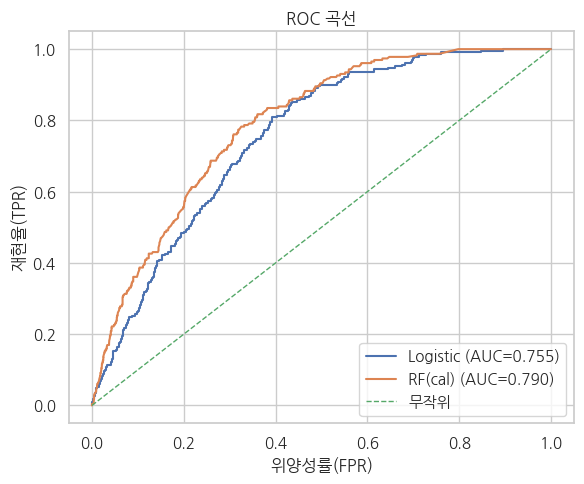

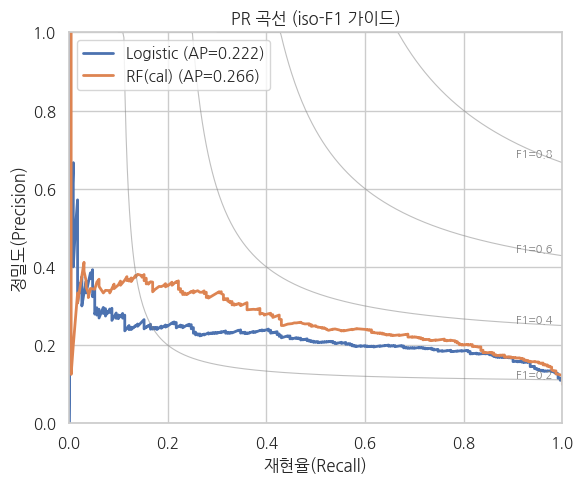

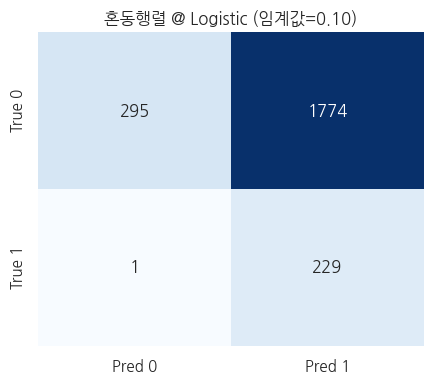

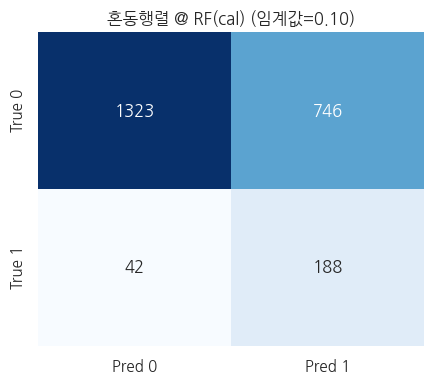

<Figure size 600x500 with 0 Axes>

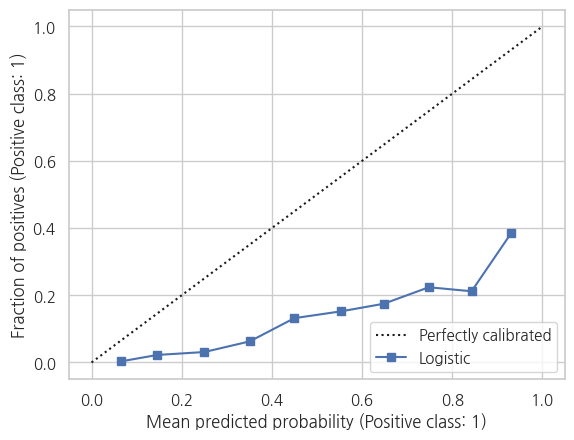

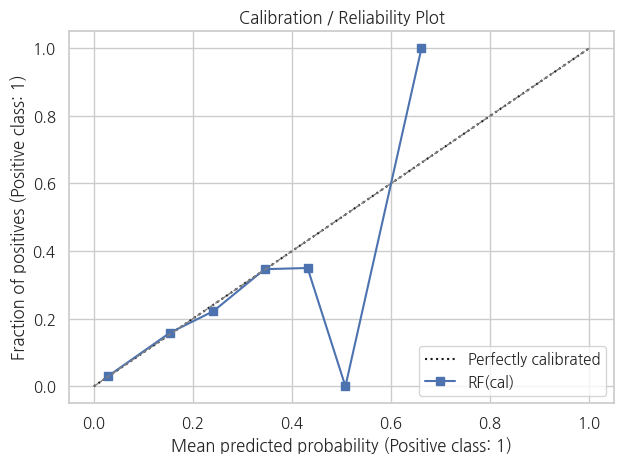

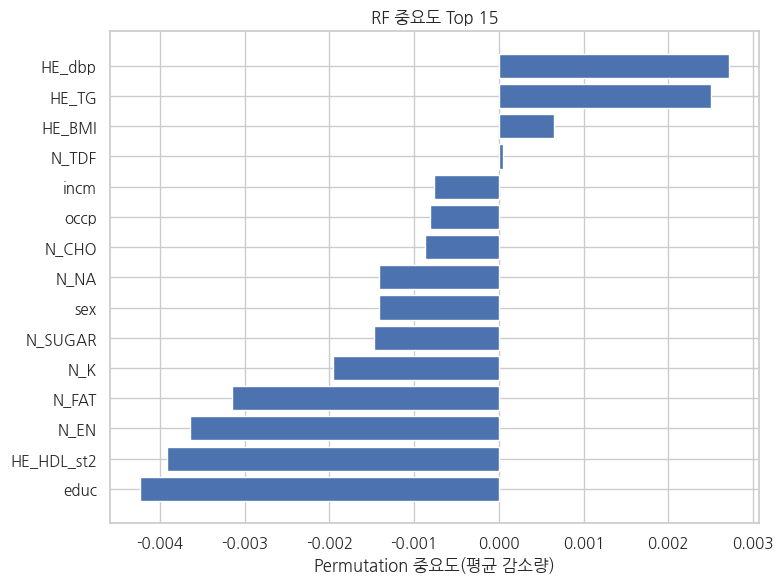

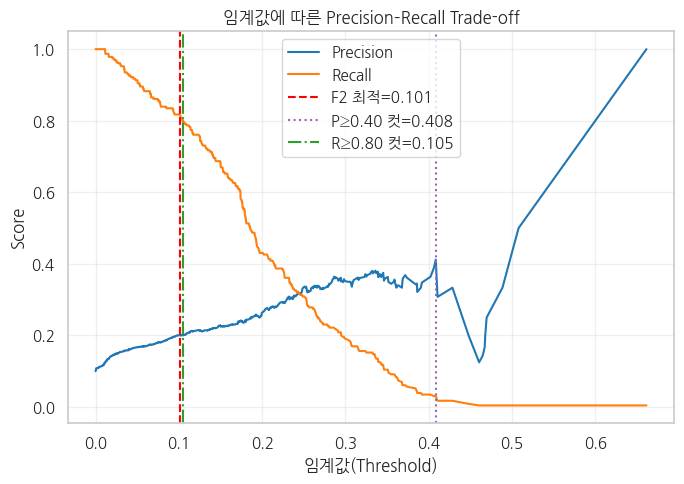

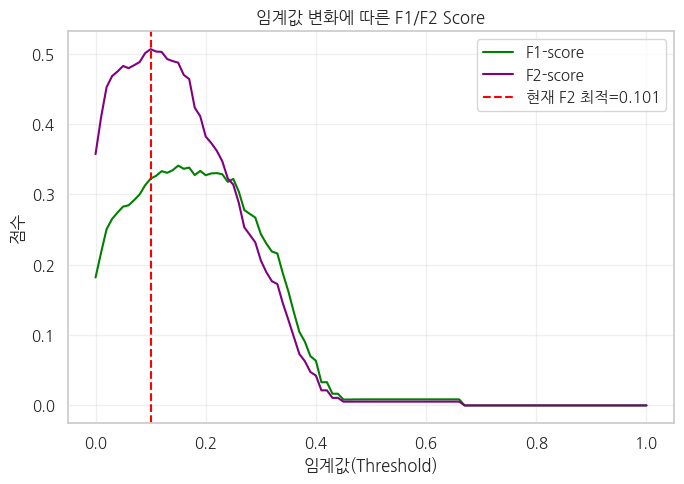


[요약 메시지]
- 누수 제거 → 진짜 사전 예측 성능 확보
- PR-AUC 기반 튜닝 + 확률보정 → 불균형/의료 스크리닝에 적합
- F2 최적 임계값≈0.101 (스크리닝/놓치지 않기 우선), F1 최적≈0.171 (균형형)
- Threshold 유틸로 Precision/Recall 목표형 컷을 바로 산출 가능


In [6]:
# -*- coding: utf-8 -*-
"""
============================================================
# 목표: 건강검진/영양 데이터로 '당뇨 위험(0/1 이진분류)' 예측

# 모델링:“현장 스크리닝 필터”
# 건강검진, 직장검진, 모바일 헬스앱, 보험사 사전심사 등 현장에서
#“이 사람은 당뇨 위험이 높으니 정밀검사를 권장하자”
#     → 이런 식으로 1차 걸러내는 시스템


# 핵심 설계와 이유:
#  - 누수 차단: HbA1c/DM 관련 열을 입력에서 제거 → 미래 예측력 보장
#  - 전처리 일원화: 결측 대치 + 스케일링 + 원핫 → 재현/배포에 안전
#  - 모델 2종: Logistic(해석) + RF(비선형 성능) → 상호보완
#  - 튜닝: 불균형 데이터에 적합한 PR-AUC(평균정밀도)로 GridSearchCV
#  - 확률 보정: RF 원시 "점수"를 Isotonic으로 '신뢰 가능한 확률'로 보정
#  - 임계값 최적화: F2(재현율 가중) 기준 컷오프 선택(스크리닝 목적 적합)
#  - 리포트/시각화: ROC/PR(+iso-F1), 혼동행렬, 캘리브레이션, 중요도,
#                  Threshold–Precision/Recall, Threshold–F1/F2
# ============================================================
"""



# ============ 0) 기본 임포트 ============
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report, fbeta_score
)
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
SAVE_FIGS = False  # True면 PNG 저장

# ============ 1) 데이터 로드 ============
# 왜: 한국어 CSV는 cp949/EUC-KR이 흔함 → 안전하게 순차 시도
DATA_PATH = "/content/modeling_dataset_hba1c_Excel.csv" #코랩에서 사전 데이터 업로드
assert os.path.exists(DATA_PATH), f"CSV 파일이 없습니다: {DATA_PATH}"

def read_korean_csv(path):
    for enc in ("cp949", "euc-kr", "utf-8"):
        try:
            return pd.read_csv(path, encoding=enc)
        except UnicodeDecodeError:
            continue
    raise ValueError("CSV 인코딩을 판별하지 못했습니다.")
df = read_korean_csv(DATA_PATH)
print(f"[데이터] 크기={df.shape}, 예시컬럼={list(df.columns)[:12]}")

# ============ 2) 누수 차단 ============
# 왜: 타깃과 직접/간접으로 연결된 신호(HbA1c/DM)가 입력에 있으면 '답안 유출' 상태가 되어
#     교차검증 성능은 높게 보이나, 실전 일반화가 붕괴!!
leak_cols = [c for c in df.columns if ("hba1c" in c.lower()) or ("_dm_" in c.lower())]
if leak_cols:
    print("[누수 제거] 제외:", leak_cols)
    df = df.drop(columns=leak_cols, errors="ignore")

# ============ 3) 타깃/입력 분리 ============
assert "당뇨_위험" in df.columns, "'당뇨_위험' 컬럼이 없습니다."
y = df["당뇨_위험"].astype(int)
X = df.drop(columns=["당뇨_위험"])

# ============ 4) 컬럼 타입 자동 식별 ============
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]
print(f"[타입] 수치 {len(num_cols)}개, 범주 {len(cat_cols)}개")

# ============ 5) 전처리 파이프라인 ============
# 왜:
#  - 수치: 중앙값 대치(이상치 둔감) + 표준화(로지스틱 안정성/계수 해석)
#  - 범주: 최빈값 대치 + 원-핫(미등록 카테고리 무시)
def make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:  # 구버전 호환
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  make_ohe())
])
preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

# ============ 6) 학습/평가 분할(층화) ============
# 왜: 불균형(양성 희귀)에서 층화 분할로 클래스 비율 유지
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# ============ 7) 모델 구성 ============
# Logistic: 해석(변수 방향/크기)
logit = Pipeline([
    ("pre", preprocess),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])
# RF: 비선형/상호작용, 클래스 불균형 시 강건
rf_base = Pipeline([
    ("pre", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1,
        class_weight="balanced_subsample"
    ))
])

# ============ 8) RF 하이퍼파라미터 튜닝(PR-AUC) ============
# 왜: 희귀 양성에서는 ROC보다 PR-AUC(평균정밀도)가 운영 적합
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
param_rf = {
    "clf__max_depth": [None, 8, 12],
    "clf__min_samples_leaf": [1, 5, 10],
    "clf__max_features": ["sqrt", 0.5]
}
gs_rf = GridSearchCV(
    rf_base, param_rf, scoring="average_precision",
    cv=cv, n_jobs=-1, verbose=0
)
gs_rf.fit(X_train, y_train)
rf_best = gs_rf.best_estimator_
print(f"[GridSearch] best={gs_rf.best_params_} | best AP(cv)={gs_rf.best_score_:.4f}")

# ============ 9) 확률 보정(Isotonic) + 학습 ============
# 왜: RF 점수는 '확률처럼 보이는 점수'일 뿐 → Isotonic으로 신뢰 가능한 확률로 보정
cal_rf = CalibratedClassifierCV(rf_best, method="isotonic", cv=5)
cal_rf.fit(X_train, y_train)
logit.fit(X_train, y_train)

# ============ 10) 기본 지표(ROC/PR) ============
proba_logit = logit.predict_proba(X_test)[:, 1]
proba_rf    = cal_rf.predict_proba(X_test)[:, 1]

roc_logit = roc_auc_score(y_test, proba_logit)
roc_rf    = roc_auc_score(y_test, proba_rf)
ap_logit  = average_precision_score(y_test, proba_logit)
ap_rf     = average_precision_score(y_test, proba_rf)

print(f"[성능] Logistic  ROC-AUC={roc_logit:.3f} | PR-AUC={ap_logit:.3f}")
print(f"[성능] RF(cal)   ROC-AUC={roc_rf:.3f} | PR-AUC={ap_rf:.3f}")

# ============ 11) 임계값 최적화(F2/F1) & 목표형 컷 찾기 ============
def best_threshold_by_fbeta(y_true, proba, beta=2.0):
    ths = np.linspace(0, 1, 1001)
    scores = [fbeta_score(y_true, (proba>=t).astype(int), beta=beta) for t in ths]
    i = int(np.argmax(scores))
    return ths[i], scores[i]

def threshold_for_target_precision(y_true, proba, target_p=0.4):
    p, r, th = precision_recall_curve(y_true, proba)
    idx = np.where(p[:-1] >= target_p)[0]
    if len(idx)==0: return None
    return th[idx[0]]

def threshold_for_target_recall(y_true, proba, target_r=0.8):
    p, r, th = precision_recall_curve(y_true, proba)
    idx = np.where(r[:-1] >= target_r)[0]
    if len(idx)==0: return None
    return th[idx[-1]]  # 가장 보수적인 임계값

thr_f2, f2_val = best_threshold_by_fbeta(y_test, proba_rf, beta=2.0)
thr_f1, f1_val = best_threshold_by_fbeta(y_test, proba_rf, beta=1.0)
thr_p40 = threshold_for_target_precision(y_test, proba_rf, target_p=0.40)
thr_r80 = threshold_for_target_recall(y_test, proba_rf, target_r=0.80)
print(f"[임계값] F2 최적={thr_f2:.3f} (F2={f2_val:.3f}) | F1 최적={thr_f1:.3f} (F1={f1_val:.3f})")
print(f"[임계값] Precision≥0.40 → {None if thr_p40 is None else round(thr_p40,3)}")
print(f"[임계값] Recall≥0.80    → {None if thr_r80 is None else round(thr_r80,3)}")

# ============ 12) 스냅샷 리포트(선택 임계값 기준) ============
def snapshot_report(name, y_true, proba, thr):
    pred = (proba >= thr).astype(int)
    cm = confusion_matrix(y_true, pred)
    print(f"\n[{name}] thr={thr:.3f}")
    print(classification_report(y_true, pred, digits=3))
    print("Confusion Matrix:\n", cm)
    return {"model": name, "threshold": thr,
            "roc_auc": roc_auc_score(y_true, proba),
            "ap": average_precision_score(y_true, proba),
            "tp": cm[1,1], "fp": cm[0,1], "tn": cm[0,0], "fn": cm[1,0]}

rep_logit = snapshot_report("Logistic", y_test, proba_logit, thr_f2)   # 비교를 위해 동일 컷 사용 가능
rep_rf    = snapshot_report("RF(cal)", y_test, proba_rf,    thr_f2)
summary_df = pd.DataFrame([rep_logit, rep_rf])
print("\n=== Summary @F2 최적 임계값 ===")
display(summary_df[["model","threshold","roc_auc","ap","tp","fp","tn","fn"]])




# ============ 13) 시각화 ============

# 한글 폰트 유지용 (sns.set이 rcParams를 덮어쓰는 문제 해결)
from matplotlib import rcParams
FONT_KO = rcParams["font.family"][0] if isinstance(rcParams["font.family"], list) else rcParams["font.family"]
sns.set(style="whitegrid", font=FONT_KO, rc={"axes.unicode_minus": False})

# 13-1) ROC 곡선
fpr_l, tpr_l, _ = roc_curve(y_test, proba_logit)
fpr_r, tpr_r, _ = roc_curve(y_test, proba_rf)
plt.figure(figsize=(6,5))
plt.plot(fpr_l, tpr_l, label=f'Logistic (AUC={roc_logit:.3f})')
plt.plot(fpr_r, tpr_r, label=f'RF(cal) (AUC={roc_rf:.3f})')
plt.plot([0,1],[0,1],'--', lw=1, label='무작위')
plt.xlabel('위양성률(FPR)'); plt.ylabel('재현율(TPR)'); plt.title('ROC 곡선')
plt.legend(); plt.tight_layout()
if SAVE_FIGS: plt.savefig("roc.png", dpi=150)
plt.show()

# 13-2) PR 곡선 + iso-F1(안정 버전)
def plot_pr_with_iso(y_true, proba, label):
    prec, rec, _ = precision_recall_curve(y_true, proba)
    plt.plot(rec, prec, lw=2, label=label)

plt.figure(figsize=(6,5))
plot_pr_with_iso(y_test, proba_logit, f'Logistic (AP={ap_logit:.3f})')
plot_pr_with_iso(y_test, proba_rf,    f'RF(cal) (AP={ap_rf:.3f})')
for f1 in (0.2, 0.4, 0.6, 0.8):
    r = np.linspace(f1/2 + 1e-6, 1.0, 400)   # 발산 구간 제외
    p = (f1 * r) / (2*r - f1)
    p = np.clip(p, 0, 1)
    plt.plot(r, p, color='gray', lw=0.8, alpha=0.5)
    plt.text(0.98, (f1*0.98)/(2*0.98 - f1), f'F1={f1}', ha='right', va='bottom', fontsize=8, color='gray')
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel('재현율(Recall)'); plt.ylabel('정밀도(Precision)'); plt.title('PR 곡선 (iso-F1 가이드)')
plt.legend(); plt.tight_layout()
if SAVE_FIGS: plt.savefig("pr.png", dpi=150)
plt.show()

# 13-3) 혼동행렬(운영 컷: F2 최적)
from itertools import product
for name, proba, thr in [("Logistic", proba_logit, thr_f2), ("RF(cal)", proba_rf, thr_f2)]:
    pred = (proba >= thr).astype(int)
    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(4.5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'])
    plt.title(f'혼동행렬 @ {name} (임계값={thr:.2f})')
    plt.tight_layout()
    if SAVE_FIGS: plt.savefig(f"cm_{name}.png", dpi=150)
    plt.show()

# 13-4) 캘리브레이션(신뢰도) 플롯
plt.figure(figsize=(6,5))
CalibrationDisplay.from_predictions(y_test, proba_logit, n_bins=10, name='Logistic')
CalibrationDisplay.from_predictions(y_test, proba_rf,    n_bins=10, name='RF(cal)')
plt.plot([0,1],[0,1],'--', color='gray', lw=1)
plt.title('Calibration / Reliability Plot')
plt.tight_layout()
if SAVE_FIGS: plt.savefig("calibration.png", dpi=150)
plt.show()

# 13-5) RF Permutation 중요도(Top 15)
pi = permutation_importance(rf_best, X_test, y_test, n_repeats=8,
                            random_state=RANDOM_STATE, n_jobs=-1)
pi_mean = pi.importances_mean
top_idx = np.argsort(pi_mean)[::-1][:15]
feat_names = np.array(list(num_cols) + list(cat_cols))  # 원피처 이름 기준(파이프라인 전)
plt.figure(figsize=(8,6))
plt.barh(range(len(top_idx)), pi_mean[top_idx][::-1])
plt.yticks(range(len(top_idx)), feat_names[top_idx][::-1])
plt.xlabel('Permutation 중요도(평균 감소량)'); plt.title('RF 중요도 Top 15')
plt.tight_layout()
if SAVE_FIGS: plt.savefig("rf_importance.png", dpi=150)
plt.show()

# 13-6) 임계값–Precision/Recall Trade-off
precisions, recalls, thresholds = precision_recall_curve(y_test, proba_rf)
plt.figure(figsize=(7,5))
plt.plot(thresholds, precisions[:-1], label='Precision', color='tab:blue')
plt.plot(thresholds, recalls[:-1],    label='Recall',    color='tab:orange')
plt.axvline(thr_f2, ls='--', color='red', label=f'F2 최적={thr_f2:.3f}')
if thr_p40: plt.axvline(thr_p40, ls=':',  color='tab:purple', label=f'P≥0.40 컷={thr_p40:.3f}')
if thr_r80: plt.axvline(thr_r80, ls='-.', color='tab:green',  label=f'R≥0.80 컷={thr_r80:.3f}')
plt.xlabel('임계값(Threshold)'); plt.ylabel('Score'); plt.title('임계값에 따른 Precision–Recall Trade-off')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
if SAVE_FIGS: plt.savefig("thr_pr_tradeoff.png", dpi=150)
plt.show()

# 13-7) 임계값–F1/F2 곡선
ths = np.linspace(0, 1, 101)
f1s = [fbeta_score(y_test, (proba_rf>=t).astype(int), beta=1) for t in ths]
f2s = [fbeta_score(y_test, (proba_rf>=t).astype(int), beta=2) for t in ths]
plt.figure(figsize=(7,5))
plt.plot(ths, f1s, label='F1-score', color='green')
plt.plot(ths, f2s, label='F2-score', color='purple')
plt.axvline(thr_f2, ls='--', color='red', label=f'현재 F2 최적={thr_f2:.3f}')
plt.xlabel('임계값(Threshold)'); plt.ylabel('점수'); plt.title('임계값 변화에 따른 F1/F2 Score')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
if SAVE_FIGS: plt.savefig("thr_f1f2.png", dpi=150)
plt.show()

print("\n[요약 메시지]")
print("- 누수 제거 → 진짜 사전 예측 성능 확보")
print("- PR-AUC 기반 튜닝 + 확률보정 → 불균형/의료 스크리닝에 적합")
print(f"- F2 최적 임계값≈{thr_f2:.3f} (스크리닝/놓치지 않기 우선), F1 최적≈{thr_f1:.3f} (균형형)")
print("- Threshold 유틸로 Precision/Recall 목표형 컷을 바로 산출 가능")
